In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import os
import os.path as osp
import collections
import PIL
import imageio
from distutils.version import LooseVersion
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# # Downloading dataset from google drive, 밑의 코드의 주석을 풀면 구글 드라이브로 부터 데이터셋 다운, 압축이 풀리고, Kitti라는 폴더가 생성됩니다. 

# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19EiycfOQtf6uDKvMgwlHZB50cAxX_U4z' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19EiycfOQtf6uDKvMgwlHZB50cAxX_U4z" -O Kitti.zip && rm -rf /tmp/cookies.txt
# !mkdir Kitti
# !unzip Kitti.zip -d Kitti


# Dataloader

In [3]:
imgsets_file = osp.join('Kitti', '{}.txt'.format('train'))
for line in open(imgsets_file):
    line = line.strip()
#     import pdb; pdb.set_trace()
    print(line)
    line = line.split()

training/image_2/um_000000.png training/gt_image_2/um_road_000000.png
training/image_2/um_000001.png training/gt_image_2/um_road_000001.png
training/image_2/um_000002.png training/gt_image_2/um_road_000002.png
training/image_2/um_000003.png training/gt_image_2/um_road_000003.png
training/image_2/um_000004.png training/gt_image_2/um_road_000004.png
training/image_2/um_000005.png training/gt_image_2/um_road_000005.png
training/image_2/um_000006.png training/gt_image_2/um_road_000006.png
training/image_2/um_000007.png training/gt_image_2/um_road_000007.png
training/image_2/um_000008.png training/gt_image_2/um_road_000008.png
training/image_2/um_000009.png training/gt_image_2/um_road_000009.png
training/image_2/um_000010.png training/gt_image_2/um_road_000010.png
training/image_2/um_000011.png training/gt_image_2/um_road_000011.png
training/image_2/um_000012.png training/gt_image_2/um_road_000012.png
training/image_2/um_000013.png training/gt_image_2/um_road_000013.png
training/image_2/um_

In [4]:
class KITTIdataset(torch.utils.data.Dataset):
    class_names = np.array(['background', 'road'])

    def __init__(self, root, transform, split='train'): # root: "./Kitti"
        ## split에 맞는 txt파일 읽어서, 
        ## input image label image경로 리스트로 각각 저장
        self.root = root
        self.transform = transform
        self.split = split
        
        self.images_path = []
        self.ys = []
        
        imgsets_file = osp.join('Kitti', '{}.txt'.format(split)) # train, val
        for line in open(imgsets_file):
            line = line.strip() #"\n"
            line = line.split() # line[0]: input image path, # line[1]: label image
            img_file = osp.join("./Kitti/data_road", "{}".format(line[0]))
            lbl_file = osp.join("./Kitti/data_road", "{}".format(line[1]))
            self.images_path.append(img_file)
            self.ys.append(lbl_file)
            
    def __len__(self):
        ## length return
        return len(self.ys)
    
    def __getitem__(self, index):
        ## index에 맞는 image, label image읽어오기
        # load image
        img_file = self.images_path[index]
        img = PIL.Image.open(img_file)
        img = np.array(img)
        
        # load label
        lbl_file = self.ys[index]
        lbl = PIL.Image.open(lbl_file)
        lbl = np.array(lbl) ## black: 0, white: 255 255->1
        lbl[lbl == 255] = 1 ## 0, 1
        
        return self.transform(img), torch.from_numpy(lbl).long()

## Define dataset and dataloader

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
train_dataset = KITTIdataset(root = './Kitti', split = 'train', transform = transform)
val_dataset = KITTIdataset(root = './Kitti', split = 'val', transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle = False)

In [6]:
# print(train_dataset[7][0].shape) ## [0]: img tensor, [1]: label tensor

# Define the Network
-VGG16

- FCN model

In [7]:
class FCN(nn.Module):
    def __init__(self, num_class = 3):
        super(FCN, self).__init__()
        
        ## conv1
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 100 ), # fix h, w
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, stride =2 , ceil_mode = True)
        
        ## conv2
        self.features2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU()
        )
        ## self.pool2
        
        ## conv3
        self.features3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU()
        )
        ### pool3
        ## conv4
        self.features4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU()
        )
        ### pool4
        
        ## conv5
        self.features5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding =1 ),
            nn.ReLU()
        )
        ## pool 5
        
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size = 7), ## reduce spatial dimension 
            nn.ReLU(),
            nn.Conv2d(4096, 4096, kernel_size = 1), ## keep spatial dimension 
            nn.ReLU(),
            nn.Conv2d(4096, num_class, 1) ## keep spatial dimension 
        )
        
        self.score_pool4 = nn.Conv2d(512, num_class, 1)
        self.score_pool3 = nn.Conv2d(256, num_class, 1)
        
        ## upsampling transposed convolution
        self.upscore2_1 = nn.ConvTranspose2d(
            num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore2_2 = nn.ConvTranspose2d(
            num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore8 = nn.ConvTranspose2d(
            num_class, num_class, kernel_size = 16, stride = 8, bias = False)
        
        self.params = [self.features1, self.features2, self.features3, 
                       self.features4, self.features5]
        

                             
    def forward(self, inputs):
        # input [Batch size, 3, w, h]
        x = self.features1(inputs)
        pool1 = self.pool(x)
        
        x = self.features2(pool1)
        pool2 = self.pool(x)
        
        x = self.features3(pool2)
        pool3 = self.pool(x)
        
        x = self.features4(pool3)
        pool4 = self.pool(x) ## channel 512
        
        x = self.features5(pool4)
        pool5 = self.pool(x)
        
        x = self.classifier(pool5) ## channel num_class
        
        x = self.upscore2_1(x) ## 2배 키워줌
        pool4 = self.score_pool4(pool4) ## channel 512 -> 2
        ## h, w
        ## pool4를 x size와 맞도록 잘라줌
        pool4 = pool4[:, :, 5:5 + x.size()[2], 5:5 + x.size()[3]] 
        x = torch.add(x, pool4) #더해줌
        
        x = self.upscore2_2(x) ##2배 키워줌
        pool3 = self.score_pool3(pool3) ## channel 256 -> 2
        pool3 = pool3[:, :, 9:9 + x.size()[2], 9:9 + x.size()[3]] # cut
        x = torch.add(x, pool3)
        
        x = self.upscore8(x) # w, h
        
        ## cut x to match the input size
        x = x[:, :, 33:33 + inputs.size()[2], 33:33 + inputs.size()[3]]
        
        return x ## label map [batch, num_class, inputs h, input w]
    
    def copy_params(self, vgg):
        for l1, l2 in zip(vgg.features, self.params):
            if (isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d)):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

In [8]:
import torch.nn as nn
import torch

test = torch.randn(2,3,32,32)
x = torch.tensor([[-2, 1, 2, 6, 4], [-3, 1, 7, 2, -2], [-4, 2, 3, -1 , -3], [-7, 1, 2, 3, 11], [5, -7, 8, 12, -9]]).float()
x = x.unsqueeze(0)
y_1 = nn.MaxPool2d(kernel_size=2,stride=2, padding=0)
y_2 = nn.MaxPool2d(kernel_size=2,stride=2, padding=0, ceil_mode=True)
print(x)
print(y_1(x))
print(y_2(x))

tensor([[[-2.,  1.,  2.,  6.,  4.],
         [-3.,  1.,  7.,  2., -2.],
         [-4.,  2.,  3., -1., -3.],
         [-7.,  1.,  2.,  3., 11.],
         [ 5., -7.,  8., 12., -9.]]])
tensor([[[1., 7.],
         [2., 3.]]])
tensor([[[ 1.,  7.,  4.],
         [ 2.,  3., 11.],
         [ 5., 12., -9.]]])


In [9]:
m1 = nn.ConvTranspose2d(2, 2, kernel_size = 4, stride = 2, bias = False)
m2 = nn.ConvTranspose2d(2, 2, kernel_size = 4, stride = 2, bias = False)
m3 = nn.ConvTranspose2d(2, 2, kernel_size = 16, stride = 8, bias = False)
temp_input = torch.randn(1,2,50,50)
temp_output = m3(temp_input)
print(temp_input.size())
print(temp_output.size())

torch.Size([1, 2, 50, 50])
torch.Size([1, 2, 408, 408])


In [10]:
# model = FCN(2)
# # # print(model)
# temp_input = torch.rand(1, 3, 1024, 1024)
# output = model(temp_input)
# print(output.shape)

## Measure accuracy and visualization

In [17]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    
    hist = np.bincount(
        n_class * label_true[mask].astype(int) + label_pred[mask], 
        minlength = n_class**2
    ).reshape(n_class, n_class)
    
    return hist

def compute_mean_iou(label_trues, label_preds, n_class): 
    # label_true: [h, w] # label_pred: [h, w] # n_class: 2
    # 2 *2 tensor
    hist = np.zeros((n_class, n_class)) ## 2*2 zero 
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    iu = np.diag(hist) / (hist.sum(axis = 1) + hist.sum(axis = 0) - np.diag(hist))
    mean_iou = np.nanmean(iu)
    return mean_iou

def visualization(net, input_img, epoch):
    img = transform(input_img).unsqueeze(0)
    img = img.cuda()
    
    score = net(img)
    score = score["out"]
    
    os.makedirs("./pred", exist_ok = True)
    os.makedirs("./input", exist_ok = True)
    _, lbl_pred = score.max(1)
    lbl_pred = lbl_pred.cpu().numpy()  
    lbl_pred = np.squeeze(lbl_pred)
    imageio.imsave('./pred/mask_'+str(epoch+1)+'.png', lbl_pred)
    plt.imshow(mpimg.imread('./pred/mask_'+str(epoch+1)+'.png'),cmap='gray') ### visualize predicted label map
    plt.show()
    input_img = np.array(input_img)
    imageio.imsave('./input/input_'+str(epoch+1)+'.png', input_img)
    plt.imshow(mpimg.imread('./input/input_'+str(epoch+1)+'.png'))
    plt.show()
    

In [12]:
label_true = np.array([
    [1, 2],
    [2, 3]
])
label_pred = np.array([
    [1, 2],
    [2, 2]
])

compute_mean_iou(label_true, label_pred, 4)

<ipython-input-11-43f24d7ed3df>:17: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis = 1) + hist.sum(axis = 0) - np.diag(hist))


0.5555555555555555

# Train

In [13]:
##load pretrained model from torchvision
##pretrained using coco 2017
net = torchvision.models.segmentation.fcn_resnet50(pretrained = True)
# print(net)
net.classifier = torchvision.models.segmentation.fcn.FCNHead( 2048, 2)
net = net.cuda()
print(net)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [14]:
# vgg16 = torchvision.models.vgg16(pretrained = True)
# net = FCN(num_class = 2)
# net.copy_params(vgg16)

# net = net.cuda()

In [15]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay = 0.0001)

In [18]:
training_epochs = 5
best_iou = 0
num_class = len(train_loader.dataset.class_names)
j=0

for epoch in range(training_epochs):
    net.train()
    print ('current epoch : %d'%(epoch))
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        # load data, forward
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        
        score = net(data)
        score = score["out"]

        loss = criterion(score, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 20 ==0:
            print ('batch : {}, loss : {}'.format(batch_idx, loss.item()))
        j += 1
        
    #validation
    net.eval()
    val_loss = 0
    metrics = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            # load data, forward
            data, target = data.cuda(), target.cuda()
            score = net(data)
            score = score["out"]

            # calc val loss, accuracy
            loss = criterion(score, target)

            val_loss += loss.item()

            _, lbl_pred = score.max(1)
            lbl_pred = lbl_pred.cpu().numpy()  
            lbl_true = target.cpu().numpy()

            for lt, lp in zip(lbl_true, lbl_pred): # lbl_true, lbl_pred: [batch, h, w]
                tmp = compute_mean_iou(lt, lp, num_class)
                metrics.append(tmp)
            
    val_loss /= len(val_loader)
    metrics = np.mean(metrics)
    
    print ('val loss : {}, mean_iou : {}'.format(val_loss, metrics))

    ##save model
    if best_iou < metrics:
        best_iou = metrics
        print("Best model saved")
        torch.save(net.state_dict(), './model_best.pth')
    
    ## visualization
    img = PIL.Image.open('./road_sample1.png')
    visualization(net, img, epoch)
print('Finished Training')

current epoch : 0
batch : 0, loss : 0.681321918964386
batch : 20, loss : 0.2983052432537079
batch : 40, loss : 0.1799585223197937


KeyboardInterrupt: 

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


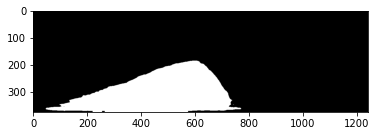

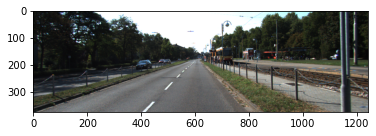

In [19]:
img = PIL.Image.open('./road_sample1.png')
visualization(net, img, epoch)